<a href="https://colab.research.google.com/github/rthorst/Technical_Presentations/blob/master/Twitter_Mining/Twitter_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Mining Tutorial

Robert Thorstad & Rob O'Reilly  
Emory University Center for Digital Scholarship

# Overview

In overview, mining twitter involves: 

1. **Acquiring tweets** (via something called an API)
2. **Extracting data** from those tweets (a few options: we recommend writing a JSON or CSV file)
3.  **Analyzing tweets** (mostly beyond our scope, but we'll do a simple analysis)

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/great_debate.png)

As an example, we'll take on a "great debate." For example:

- Ketchup or mustard?
- Coffee or tea?
- Windows or Mac?

**We'll ask which one is better**, and we'll do this by mining recent tweets about each keyword and analyzing how positive those tweets are, a technique known as sentiment analysis. 



In [0]:
# Define topics for our great debate -- from the audience!
topic1 = "coffee"
topic2 = "tea"

# Acquiring Tweets

Tweets can be acquired in a few ways:

1. **Searching for a keyword.** We'll do this today: twitter "search" API.

2. **Other options.** There are several other options we won't cover today. Notable options include a "user timeline" of all of a single user's tweets (up to 3,200/user), and a live "firehose" which is a random sample of all tweets in real time. 


# Tweepy: Python Library for Twitter API

Large websites like twitter make data available programmatically through an **Application Program Interface (API).** We'll use the Python library **tweepy** to access the twitter API.

If you want to work outside of Python, see https://developer.twitter.com/en/docs for API documentation.

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/tweepy.PNG)

To access the API, you need an **api key** (identifies you) and a **twitter developer account.** These are free:  https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens (API key) and https://developer.twitter.com/en/apply-for-access (developer account).



![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/apply_developer_account.PNG)


In [0]:
import tweepy

# Define our API key, acquired from https://developer.twitter.com/en/docs/basics/authentication/guides/access-tokens
# Replace with your personal API key.
# Note! Never publicly share your API key; treat it as you would any other password. 
consumer_key = "kNOG1klRMMUYbsjMuY5TKl4lE"
consumer_secret = "ieghv6WI1qseYly43A0Ra1MPksEw1i5Onma0txfEu5aHantD2v"
access_key = "3291622062-15ssVc0qpJXf2SFXbA7vgfl1Sooz4Ueo2DGPQVz"
access_secret = "9XJuzgGSVLnx93tq6NfRzMT07S6o2lzjmHfjt3VRlkqXn"

# Create API object. Yes, just 3 lines of code!!
auth = tweepy.OAuthHandler(consumer_key, consumer_secret) # authorize.
auth.set_access_token(access_key, access_secret) # specify our credentials. 
api = tweepy.API(auth, wait_on_rate_limit = True) # wait_on_rate_limit option is strongly recommended: prevents being locked out for making too many queries.

## Getting Tweets Using a Keyword

Here, we use the **search API** to get recent tweets based on a keyword.

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/api_search_ref.PNG)



In [0]:
# Get tweets for each topic. Yes --- 1 line of code!!
topic1_tweets = api.search(q=topic1) # list: shape (ntweets, )
topic2_tweets = api.search(q=topic2) # list: shape (ntweets, ) 

In [8]:
# Visualize some example tweets. Note that {} is a type of string replacement.
topics = [topic1, topic2]
tweet_arrs = [topic1_tweets, topic2_tweets]

for topic, tweets in zip(topics, tweet_arrs):
  
  msg = """
  -----------------
  Example tweet about aboout {}:
  {}
  
  Total number of tweets about {} = {}
  -----------------
  """.format(topic, tweets[0].text, topic, len(tweets))
  
  print(msg)


  -----------------
  Example tweet about aboout coffee:
  @Hela_Odindottir @Pour_Me_Coffee_ @ILiebuster @Mahakaa11337387 @gauravcsawant @ImranKhanPTI @ShkhRasheed @RajManuja… https://t.co/mkZPA6J0KH
  
  Total number of tweets about coffee = 15
  -----------------
  

  -----------------
  Example tweet about aboout tea:
  tadinya udah planning sebelum pulang dari gancit pengen ngeshare tea dulu. biar ada yg seger sambil menikmati macet… https://t.co/zuADnzNxvS
  
  Total number of tweets about tea = 15
  -----------------
  


# Getting More Tweets.

**Oops! We only got 15 tweets/topic**. Let's modify our search to retrieve more tweets. 

Tweets come in "pages" of at most 100 tweets. So, we need to:
* Increase the "page size" (from 15 --> 100)
* Get tweets from more than one page.


In [0]:
def get_tweets_by_keyword(keyword, max_tweets=500, lang="en"):
  """
  keyword :: string, e.g. "mustard" or "flying elephants".
  max_tweets :: integer, maximum # of tweets to retrieve.
  lang :: language code, as ISO-639 e.g. "en" for "English"
  
  Return list of tweets. Each tweet is a tweepy.models.Status object
  https://gist.github.com/dev-techmoe/ef676cdd03ac47ac503e856282077bf2
   
  Note: it is possible we'll retrieve slightly more than the maximum number of
  tweets (which is usually a good thing!). If this is not desired behavior,
  modify the return statement to:
  
   >>   if len(tweets) <= max_tweets:
   >>     return tweets
   >>   else:
   >>     return tweets[:max_tweets]

  """
  
  tweets = [] # list of tweets
  max_id = None # id of the last tweet retrieved, used to search for subsequent "pages" of tweets.

  while len(tweets) < max_tweets:

    ### Retrieve tweets. ####
    

    # Logic: There are two cases.
    # Case 1: We have already acquired some tweets --> search for tweets with
    # an ID number lower than any tweet we have retrieved before.
    # Case 2: We have no tweets yet --> simply search for recent tweets.
 
    if max_id:
      new_tweets = api.search(q=keyword, lang=lang, count=100, 
                             max_id=max_id)
    else:
      new_tweets = api.search(q=keyword, lang=lang, count=100)
     
    
    ### Process the tweets just retrieved. ###
    
    # Logic: Again there are two cases.
    # Case 1: No tweets were retrieved --> Stop, can't get more tweets.
    # Case 2: Some tweets were retrieved --> Store those tweets then keep 
    # searching for more tweets.
 
    if new_tweets:     
      tweets.extend(new_tweets)
      max_id = str(new_tweets[-1].id)
    else:
      break

  return tweets


In [10]:
# Get tweets for each topic.
topic1_tweets = get_tweets_by_keyword(topic1, max_tweets=1000)
topic2_tweets = get_tweets_by_keyword(topic2, max_tweets=1000)

# See example tweets.
for topic, tweets in zip([topic1, topic2], [topic1_tweets, topic2_tweets]):
  
  msg = """
  -----------------
  Example tweet about aboout {}:
  {}
  
  Total number of tweets about {} = {}
  -----------------
  """.format(topic, tweets[0].text, topic, len(tweets))
  
  print(msg)


  -----------------
  Example tweet about aboout coffee:
  RT @MzMerica: @davidschneider At the end of the day... Nigel has just realised once/if, it’s passed, he’ll be relegated to clean the shoes…
  
  Total number of tweets about coffee = 1000
  -----------------
  

  -----------------
  Example tweet about aboout tea:
  @JeffreeStar I’m in line :((((( https://t.co/hM5dx2k1QP
  
  Total number of tweets about tea = 1000
  -----------------
  


# Other Ways to Retrieve Tweets 

Access a real time stream of tweets: the "decahose"

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/stream_tweets.png)

Get all tweets from a user: the "user timeline"

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/user_timeline.png)

# Extract information from a tweet

Each tweet is a tweepy.models.Status object. Great. But we really want information, like, the text of the tweet or its ID number. 

Let's extract that information.




# Data in a Tweet

Tweets have a LOT of data, including: 

* id
* text
* user["screen_name"]
* created_at


In [11]:
# Visualize one of the tweets.
import pprint
pprint.pprint(topic1_tweets[0]._json)

{'contributors': None,
 'coordinates': None,
 'created_at': 'Fri Nov 01 17:44:57 +0000 2019',
 'entities': {'hashtags': [],
              'symbols': [],
              'urls': [],
              'user_mentions': [{'id': 36707981,
                                 'id_str': '36707981',
                                 'indices': [3, 12],
                                 'name': 'Mandi L',
                                 'screen_name': 'MzMerica'},
                                {'id': 20098015,
                                 'id_str': '20098015',
                                 'indices': [14, 29],
                                 'name': 'David Schneider',
                                 'screen_name': 'davidschneider'}]},
 'favorite_count': 0,
 'favorited': False,
 'geo': None,
 'id': 1190323859834245120,
 'id_str': '1190323859834245120',
 'in_reply_to_screen_name': None,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to

# Extracting Text

The simplest approach is to extract just the text of a tweet. 

We don't recommend this (we suggest retaining more information and writing to a file). But, here's how to get the text. 

In [12]:
# The text of a tweet can be retrieved with the .text attribute.
topic1_tweets_text = [tw.text for tw in topic1_tweets]
topic2_tweets_text = [tw.text for tw in topic2_tweets]

# Let's see an example tweet text.
msg = "Text of an example tweet : {}".format(topic1_tweets_text[0])
print(msg)

Text of an example tweet : RT @MzMerica: @davidschneider At the end of the day... Nigel has just realised once/if, it’s passed, he’ll be relegated to clean the shoes…


# Writing Tweets to a File

We recommend writing tweets to a file. 

* **Minimum good practice** Write a CSV file with the tweet ID, text, user, and creation date.
* **Even better** Keep the whole tweet as a JSON. 

Below are functions to do each of these. You can directly use these functions with your own tweets. 


In [0]:
import csv
import json 

def tweets_to_csv(tweets, filename="tweets.csv"):
  """
  tweets : list of tweepy.models.Status objects
  filename : path to output file e.g. "tweets.csv"
  
  This function is a basic approach to writing tweets to a CSV. We write one 
  tweet per row, storing the tweet ID, text, user, and creation date. This is 
  the "minimum good practice" approach. 
  
  To store all information about a tweet (beyond this information), the recommended
  approach is to save the raw tweet JSON: see tweets_to_jsonl below. We do also
  provide a function below, tweets_to_long_csv, which writes the entire JSON to
  a CSV. However, this approach is not recommended for reasons documented in the
  tweets_to_long_csv function.
  """
  
  # Create output file and set up header.
  of = open(filename, "w", newline="") # output file object.
  header = ["tweet_id", "user", "creation_date", "tweet_text"] 
  w = csv.writer(of) # csv "writer" object.
  w.writerow(header)
  
  # Write each tweet to the file.
  for tweet in tweets:
    
    out = [tweet.id, tweet.user, tweet.created_at, tweet.text.encode("utf8")]
    w.writerow(out) # write row to file.
    
  # Done, close file.
  of.flush() # necessary to ensure the last few lines are written.
  of.close() # explicitly close output file. 

def tweets_to_jsonl(tweets, filename="tweets.jsonl"):
  """
  tweets: list of tweepy.models.Status objects
  filename : path to output file e.g. "tweets.jsonl". 
             output file is JSONL format. http://jsonlines.org/
  
  write tweets to a line-delimited JSON file (JSONL)
  store all information associated with the tweet.
  """
  
  with open(filename, "w", newline="") as of: # create output file. 
    for tweet in tweets:
      out = json.dumps(tweet._json) + "\n" # output as string. 
      of.write(out) # write output as a single row of text.
 

def tweets_to_long_csv(tweets, filename = "tweets.csv"):
    """
    tweets :: list of tweepy.Status objects.
    filename :: output filename (default tweets.csv)

    Write all information in each tweet to a CSV file specified by the
    filename argument.

    ***
    Note that this approach is *NOT* recommended. 
    ***

    JSON data is hierarchical in a way that is not naturally represented by 
    tabular data like a CSV. In other words, if you've gotten this far, we 
    recommend switching to tweets_to_jsonl above. 
    """

    # Extract the header (names of the keys) from the first tweet
    header = list(tweets[0]._json.keys())

    # Create the output CSV file and write a header.
    of = open(filename, "w", newline="")
    w = csv.writer(of)
    w.writerow(header)

    # Write each individual tweet to the output CSV.
    for tweet in tweets:

        j = tweet._json
        out = []

        for k in header:

            try:
                out.append(j[k])
            except KeyError: # in case of missing keys, fill with empty string.
                out.append("")

        # Some fields have unusual characters. Encode all fields as "ASCII"
        # encoded string.
        out = [str(v).encode("ascii", "ignore") for v in out]

        # Write this row to the CSV.
        w.writerow(out)

    # Done. Close output file.
    of.flush()
    of.close()

    return None
 

# Sentiment Analysis

Let's settle our "great debate." Sentiment Analysis is a type of natural language processing where the input is text and the output is a valence from -1 (negative) to +1 (positive).

We'll use a pretrained sentiment analysis model from https://github.com/cjhutto/vaderSentiment (paper: https://www.aaai.org/ocs/index.php/ICWSM/ICWSM14/paper/viewPaper/8109)

![alt text](https://raw.githubusercontent.com/rthorst/ECDS_Workshops/master/Twitter_Mining_Workshop/jupyter_nb_images/vader_sent.png)



In [14]:
!pip install vaderSentiment # "Magic" google colab statement to install a package. The ! executes like a shell command. 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# Score sentiment of each tweet (yes -- one line per topic!)
s = SentimentIntensityAnalyzer() 
topic1_sentiments = [s.polarity_scores(tw)["compound"] 
                     for tw in topic1_tweets_text] # "list comprehension" : https://www.pythonforbeginners.com/basics/list-comprehensions-in-python
topic2_sentiments = [s.polarity_scores(tw)["compound"] 
                     for tw in topic2_tweets_text]

# Visualize a few of the sentiment scores.
for tweet, sentiment in zip(topic1_tweets_text[:10], topic1_sentiments[:10]):
  msg = "\nTweet : {}\n, Sentiment = {}\n-------------".format(tweet, sentiment)
  print(msg)

"""
Want extra practice?  :) 

You might worry that we're keeping the keywords themselves in the analysis. This 
could bias the result, simply because one of the keywords might have a higher
sentiment score than the other.

For practice, try removing the keywords! You may try:
  -- tokenize each sentence (see twokenizer library: tokenization is non-trivial on twitter)
  -- remove keywords (practice: try a list comprehension! It's a beautiful feature of python)
  -- re-combine the keywords (python lists have a join() method)
"""


     |████████████████████████████████| 133kB 8.5MB/s 

Tweet : RT @MzMerica: @davidschneider At the end of the day... Nigel has just realised once/if, it’s passed, he’ll be relegated to clean the shoes…
, Sentiment = 0.4019
-------------

Tweet : RT @HallowEveHero: I Play A Badass On TV But I'm Like Everyone Else Off

🎊 New Alexa Bliss On Block
🎊🛇 NO Drama 
🎊 Crossovers Welcome 
🎊 #B…
, Sentiment = 0.7876
-------------

Tweet : It’s so nice talking to the ppl you meet at coffee shops. Honestly it turns to be a rejuvenating day if you’re havi… https://t.co/wP87WdxHjs
, Sentiment = 0.7264
-------------

Tweet : RT @_sydneyag: “Just had an iced coffee AND I—“ Happy Halloween from me and @lifeofrickey 🕺🏾 https://t.co/XXQnMVU12x
, Sentiment = 0.5719
-------------

Tweet : @bmstores @BritishBakeOff @DrOetkerBakes Coffee cake 💕💕
, Sentiment = 0.0
-------------

Tweet : @tamermnour Let's have a coffee then ☕
, Sentiment = 0.0
-------------

Tweet : RT @Lin_Manuel: Gmorning.
It’s better with y

"\nWant extra practice?  :) \n\nYou might worry that we're keeping the keywords themselves in the analysis. This \ncould bias the result, simply because one of the keywords might have a higher\nsentiment score than the other.\n\nFor practice, try removing the keywords! You may try:\n  -- tokenize each sentence (see twokenizer library: tokenization is non-trivial on twitter)\n  -- remove keywords (practice: try a list comprehension! It's a beautiful feature of python)\n  -- re-combine the keywords (python lists have a join() method)\n"

# Settle the Great Debate: Visualization

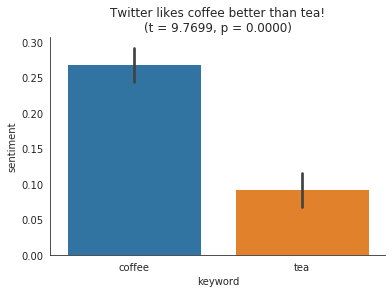

In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

"""
Reshape the data into a table-like object called a "data frame" from the 
pandas library. This step is needed for the plotting library that we use.
"""

# Combine data from topic1, topic2 tweets. The "hstack" function stacks arrays vertically on top of each other. 
tweets = np.hstack((topic1_tweets, topic2_tweets)) 
sentiments = np.hstack((topic1_sentiments, topic2_sentiments)) # ....
keywords = np.hstack((  # 
    [topic1]*len(topic1_tweets),
    [topic2]*len(topic2_tweets)
))

# Create data frame object, df.
colnames = ["tweet_text", "sentiment", "keyword"]
data = np.vstack((tweets, sentiments, keywords)).T
df = pd.DataFrame(data=data, columns=colnames)
df["sentiment"] = [float(v) for v in df.sentiment] # change data type of sentiment to numeric "floating point" values.


"""
Plot. We use the seaborn library, an elegant, high-level plotting library in
Python. Another viable alternative is matplotlib.
"""

# Generate a title programmatically, including the results of a statistical test.
t, p = ttest_ind(topic1_sentiments, topic2_sentiments) # scipy.stats has a number of statistical functions: here, t-test.
if np.mean(topic1_sentiments) > np.mean(topic2_sentiments):
  title = "Twitter likes {} better than {}!".format(topic1, topic2) # {} does string replacement.
else:
  title = "Twitter likes {} better than {}!".format(topic2, topic1)
title += "\n(t = {:.4f}, p = {:.4f})".format(t, p)

# Make plot.
sns.set_style("white")
sns.barplot(x="keyword", y="sentiment", data=df).set_title(title)
sns.despine()